In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models import MobileNetV2
from torchvision import transforms
from torchvision.datasets import GTSRB
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [9]:
len(train_dataset)

26640

5


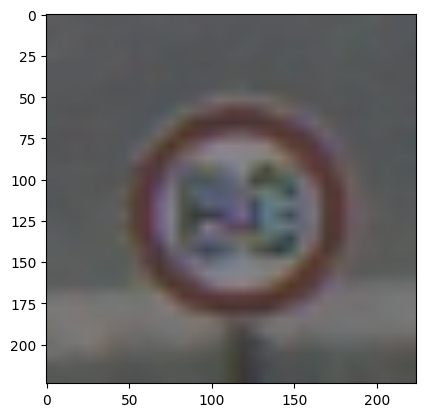

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = MobileNetV2(output_size=num_class).to(device)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MobileNetV2                                                       --
├─Sequential: 1-1                                                 --
│    └─ConvBnRelu: 2-1                                            --
│    │    └─Conv2d: 3-1                                           864
│    │    └─BatchNorm2d: 3-2                                      64
│    │    └─ReLU: 3-3                                             --
│    └─InvertedResidualBlock: 2-2                                 --
│    │    └─ResBlock: 3-4                                         2,528
│    └─InvertedResidualBlock: 2-3                                 --
│    │    └─LinearBottleneck: 3-5                                 5,136
│    └─InvertedResidualBlock: 2-4                                 --
│    │    └─LinearBottleneck: 3-6                                 8,832
│    └─InvertedResidualBlock: 2-5                                 --
│    │    └─LinearB

# training

In [13]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [14]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [15]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(train_dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 416/416 [04:04<00:00,  1.70it/s]


epoch 1: 0.013414146605733637


100%|██████████| 416/416 [01:03<00:00,  6.51it/s]


epoch 2: 0.010823541601096187


100%|██████████| 416/416 [01:03<00:00,  6.55it/s]


epoch 3: 0.008094421453080378


100%|██████████| 416/416 [01:03<00:00,  6.50it/s]


epoch 4: 0.006756957879922054


100%|██████████| 416/416 [01:03<00:00,  6.53it/s]


epoch 5: 0.005998037269971035


100%|██████████| 416/416 [01:04<00:00,  6.43it/s]


epoch 6: 0.005167796057802779


100%|██████████| 416/416 [01:04<00:00,  6.43it/s]


epoch 7: 0.004495113556113866


100%|██████████| 416/416 [01:03<00:00,  6.53it/s]


epoch 8: 0.003900525880021018


100%|██████████| 416/416 [01:03<00:00,  6.58it/s]


epoch 9: 0.0033022854432418897


100%|██████████| 416/416 [01:04<00:00,  6.47it/s]

epoch 10: 0.0029111970442573768


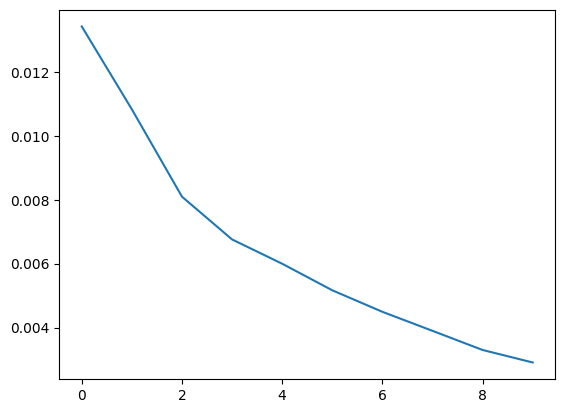

In [16]:
plt.plot(training_loss)

# inference

In [17]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [18]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [19]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [20]:
evaluator = ClassificationEvaluator(num_class, device)

In [21]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 198/198 [01:44<00:00,  1.90it/s]


In [22]:
print(confusion_matrix)

[[ 11  41   4 ...   0   0   0]
 [ 19 537  53 ...   0   0   0]
 [ 16 148 235 ...   0   0   0]
 ...
 [  0   0   1 ...  74   0   0]
 [  0   0   0 ...   0   9  11]
 [  0   1   1 ...   1  27  42]]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.18333333333333332
1         : 0.7458333333333333
2         : 0.31333333333333335
3         : 0.5311111111111111
4         : 0.28939393939393937
5         : 0.30952380952380953
6         : 0.7066666666666667
7         : 0.5777777777777777
8         : 0.42
9         : 0.8520833333333333
10        : 0.9318181818181818
11        : 0.8023809523809524
12        : 0.8695652173913043
13        : 0.9666666666666667
14        : 0.9185185185185185
15        : 0.8809523809523809
16        : 0.6133333333333333
17        : 0.8555555555555555
18        : 0.6871794871794872
19        : 0.05
20        : 0.1
21        : 0.2777777777777778
22        : 0.6
23        : 0.08
24        : 0.011111111111111112
25        : 0.59375
26        : 0.36666666666666664
27        : 0.0
28        : 0.5066666666666667
29        : 0.15555555555555556
30        : 0.07333333333333333
31        : 0.5185185185185185
32        : 0.6166666666666667
33        : 0.5142857142857142
34        : 0.925
35        : 0.938

In [24]:
per_class_acc.mean()

0.5247521446459767

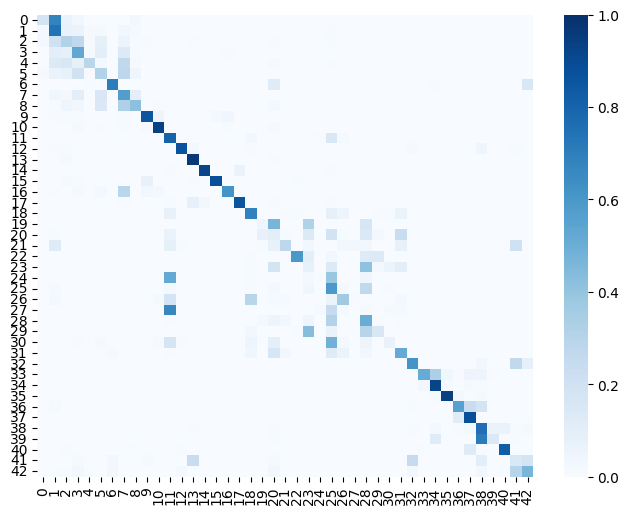

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / 'mobilenetV2.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
model_path.stat().st_size / 1024**2

9.179723739624023

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>